In [46]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyhive import hive
from pyspark.sql.functions import count
import pandas as pd

In [12]:
# Create a SparkSession with Hive support enabled
spark = SparkSession.builder \
    .appName("HotelBookingAnalysisWithHive") \
    .enableHiveSupport() \
    .getOrCreate()

#Loading the CSV file on to Spark
hotel_bookings_df = spark.read.csv("hotel_bookings.csv", header=True, inferSchema=True)


In [13]:
# Data Cleaning

# Drop Missing Values
cleaned_df = hotel_bookings_df.dropna()

# Drop Duplicate Values
cleaned_df = hotel_bookings_df.dropDuplicates()

In [14]:
# Data Normalization and/or Standardization

# Assemble the "lead_time" column into a vector
assembler = VectorAssembler(inputCols=["lead_time"], outputCol="lead_time_vector")
hotel_bookings_df = assembler.transform(hotel_bookings_df)

# Standardize numerical columns
scaler = StandardScaler(inputCol="lead_time_vector", outputCol="scaled_lead_time", withStd=True, withMean=True)
scaler_model = scaler.fit(hotel_bookings_df)
cleaned_df = scaler_model.transform(hotel_bookings_df)


In [15]:
# One Hot Encoding

indexer = StringIndexer(inputCol="hotel", outputCol="hotel_index")
encoder = OneHotEncoder(inputCol="hotel_index", outputCol="hotel_encoded")

# Create a Pipeline to execute the transformations sequentially
pipeline = Pipeline(stages=[indexer, encoder])

# Fit the pipeline to the data and transform it
transformed_df = pipeline.fit(cleaned_df).transform(cleaned_df)

transformed_df.show()


+------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+-------------+------+---------------------------+-------------------------+------------------+-----------------------+----------------+--------------------+-----------+-------------+
|       hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|company|days_in_

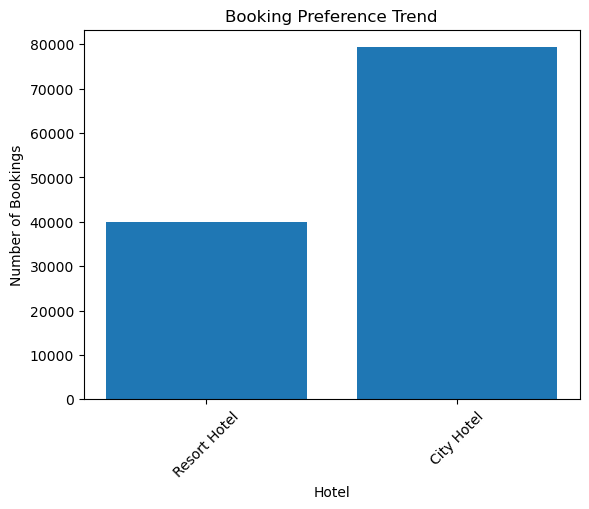

In [16]:


# Grouping and aggregation
from pyspark.sql.functions import count

booking_trend_df = cleaned_df.groupby("hotel").agg(count("*").alias("booking_count"))

# Visualization
booking_trend_df_pd = booking_trend_df.toPandas()
# Use your preferred visualization library (e.g., Matplotlib, Seaborn) to plot the booking trend
# Example: Matplotlib bar plot
import matplotlib.pyplot as plt

plt.bar(booking_trend_df_pd['hotel'], booking_trend_df_pd['booking_count'])
plt.xlabel('Hotel')
plt.ylabel('Number of Bookings')
plt.title('Booking Preference Trend')
plt.xticks(rotation=45)
plt.show()
